In [2]:
import os
from fastai.vision.all import *
from fastai.distributed import *
import cv2

ModuleNotFoundError: No module named 'fastai'

In [2]:
path = Path("data")
img_files = glob.glob(os.path.join(str(path), '*.jpg'))

In [3]:
def get_y(r):
    last = r.split("/")[-1]
    d = last.split("_")
    d[-1] = d[-1].strip(".jpg")

    return tensor([float(d[0]),float(d[1]), float(d[2]),float(d[3])])

In [4]:
data = []
for image in img_files:
    value1 = get_y(image)
    data.append(value1.numpy())

In [5]:
data = np.array(data)
print(data.shape)
min_data = data.min(axis=0)
max_data = data.max(axis=0)
print(f"Minimum values are {data.min(axis=0)}")
print(f"Maximum values are {data.max(axis=0)}")

(512, 4)
Minimum values are [5.00e+03 8.00e-01 1.03e-11 2.50e+02]
Maximum values are [1.00e+07 9.75e-01 2.30e-10 3.38e+02]


In [ ]:
np.unique(data[:,0],return_counts=True)

In [6]:
from fastai.vision.all import *
import cv2
from fastai.distributed import *
import click, argparse
import warnings
warnings.filterwarnings('ignore')

def get_x(r):
    image = Image.open(r, mode="r")
    image = image.convert('RGB')
    image = image.resize((256,256))
    return tensor(image)

def get_y(r):
    last = r.split("/")[-1]
    d = last.split("_")
    d[-1] = d[-1].strip(".jpg")
    y = []
    for i in range(4):
        y.append( (max_data[i]-float(d[i]))/(max_data[i]-min_data[i]) )
    return y

In [7]:
#     return tensor([float(d[0]),float(d[1]), float(d[2]),float(d[3])])

def splitter(items):
    """
    Splitting the data between train and loss based on the  directory name. Another function can also be defined to split the data 
    """
    valid_idx = []
    for j,(img_path) in enumerate(items):
        valid_idx.append(False)
    return IndexSplitter(mask2idxs(valid_idx))(items)

dblock = DataBlock((ImageBlock, RegressionBlock),
                           get_x = get_x, get_y = get_y,
#                            splitter = splitter,
                           batch_tfms=[*aug_transforms(size=(256,256)),
                                       Normalize.from_stats(*imagenet_stats)]) 

dsets = dblock.datasets(img_files)
dls = dblock.dataloaders(img_files,bs=16, shuffle=True,valid_pct=0.2)

In [9]:
len(dls.train.items) , len(dls.valid.items)

(410, 102)

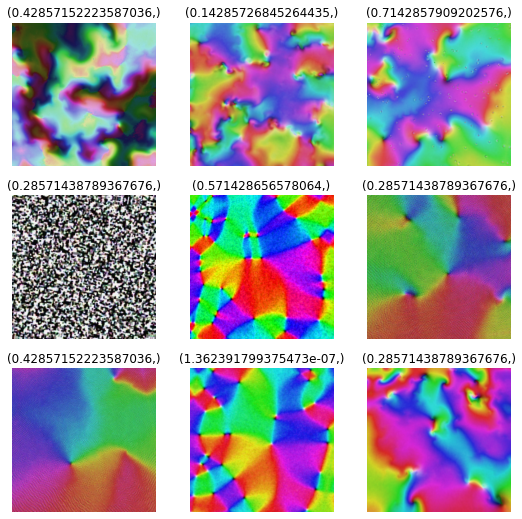

In [10]:
dls.show_batch()

In [ ]:
np.unique(data[:,3],return_counts=True)

In [ ]:
np.unique(data[:,0],return_counts=True)

In [11]:
learn = cnn_learner(dls, resnet50, y_range=(0,1), metrics=[mse,mae]) # y_range=(0,data.max())

In [ ]:
learn.loss_func

In [ ]:
learn.summary()

In [ ]:
learn.fit_one_cycle(100,1.0e-4)

epoch,train_loss,valid_loss,mse,mae,time
0,0.197224,0.192156,0.192156,0.371909,00:03
1,0.192359,0.198339,0.198339,0.368259,00:03
2,0.197654,0.175192,0.175192,0.347850,00:03
3,0.190227,0.176699,0.176699,0.348705,00:03
4,0.191382,0.154721,0.154721,0.318642,00:03
5,0.184572,0.156817,0.156817,0.318751,00:03


In [ ]:
learn.unfreeze()

learn.summary()

In [ ]:
learn.fit_one_cycle(200,1.0e-4)

In [ ]:
learn.show_results()

In [ ]:
learn.dls.valid = dls.valid

In [ ]:
results = learn.get_preds()

In [ ]:
results[0].shape , results[1].shape

In [ ]:
results[0][0], results[1][0], 

In [ ]:
from sklearn.metrics import r2_score

r2_score(results[1],results[0])